# Style Transfer

This notebook implements style transfer using pytorch with the help of VGG-16 pre-trained model.

### Load VGG-19 pre-trained model

In [1]:
import torch
from torchvision import models

model = models.vgg19(pretrained=True).features

# Freeze VGG parameters
for param in model.parameters():
    param.requires_grad_(False)

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace)
  (18): MaxPool2d(kernel_size=2, stride=2, padding=0, 

### Process Image

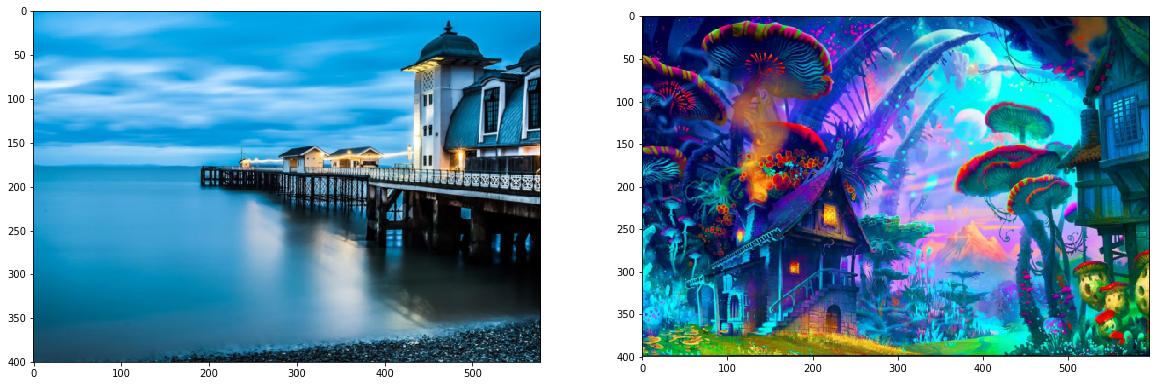

In [2]:
from PIL import Image
from torchvision import transforms
import numpy as np

def processImage(img, max_size=400, shape=None):
    image = Image.open(img).convert('RGB')
    
    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)
    
    if shape is not None:
        size = shape
    
    transform = transforms.Compose([
        transforms.Resize(size),
        transforms.ToTensor(),
        transforms.Normalize((0.485,0.456,0.406),
                            (0.229,0.224,0.225))])
    image = transform(image)[:3,:,:].unsqueeze(0)
    
    return image

content = processImage('./images/content.jpg').to(device)
style = processImage('./images/paint.jpg').to(device)

%matplotlib inline
import matplotlib.pyplot as plt

def convertImage(img):
    image = img.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.229,0.224,0.225)) + np.array((0.485,0.456,0.406))
    image = image.clip(0,1)
    return image

# Display Content and Style Images
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(convertImage(content))
ax2.imshow(convertImage(style))

### Get Features

In [3]:
def get_features(image, model):
    layers = {'0': 'conv1_1',
              '5': 'conv2_1',
              '10': 'conv3_1', 
              '19': 'conv4_1', 
              '21': 'conv4_2', 
              '28': 'conv5_1'}
        
    features = {}
    x = image
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x
            
    return features

### Gram Matrix

In [4]:
def gram_matrix(tensor):
    _, d, h, w = tensor.size()
    tensor = tensor.view(d, h * w)
    gram = torch.mm(tensor, tensor.t())
    
    return gram 

In [5]:
content_features = get_features(content, model)
style_features = get_features(style, model)

# gram matrices for each layer for style representation
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}
# Copy content image as target
target = content.clone().requires_grad_(True).to(device)

### Feed Images to the model

Total loss:  52881420.0


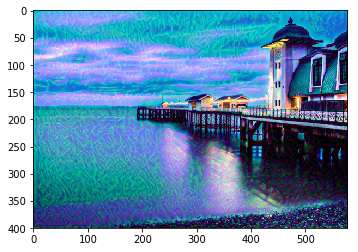

Total loss:  19639906.0


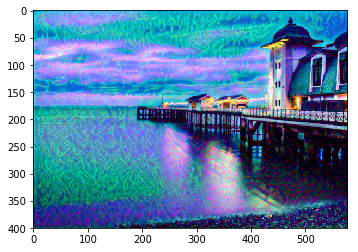

Total loss:  11270260.0


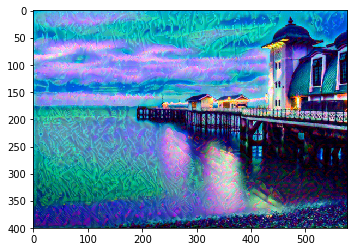

Total loss:  6996551.0


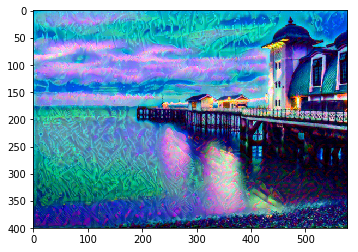

Total loss:  4796484.5


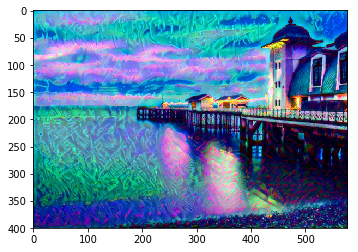

In [6]:
style_weights = {'conv1_1': 1.,
                 'conv2_1': 0.75,
                 'conv3_1': 0.2,
                 'conv4_1': 0.2,
                 'conv5_1': 0.2}

content_weight = 1
style_weight = 1e6

steps = 2000
show_every = 400

import torch.optim as optim
optimizer = optim.Adam([target], lr=0.003)

for ii in range(1, steps+1):
    target_features = get_features(target, model)
    
    content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)
    style_loss = 0

    for layer in style_weights:
        # Target's style representation
        target_feature = target_features[layer]
        target_gram = gram_matrix(target_feature)
        _, d, h, w = target_feature.shape
        
        # Style's style representation
        style_gram = style_grams[layer]
        layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
        style_loss += layer_style_loss / (d * h * w)
        
    # calculate total loss
    total_loss = content_weight * content_loss + style_weight * style_loss

    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    # display intermediate images
    if  ii % show_every == 0:
        print('Total loss: ', total_loss.item())
        plt.imshow(convertImage(target))
        plt.show()

### Display Reults

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(convertImage(content))
ax2.imshow(convertImage(target))